# Academic Success Classification 🎓

# Setup

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
train = pd.read_csv("./input/train.csv", index_col="id")
test = pd.read_csv("./input/test.csv", index_col="id")

In [75]:
train.Target.replace({"Dropout": 0, "Enrolled": 1, "Graduate": 2}, inplace=True)

# Data in a glance

📌 Original Dataset and Variables table available [here](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

📌 This dataset doesn't have missing values!

In [76]:
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,0
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,0
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,1
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,2


In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

📌 Some of these columns are categorical, let's change the dtype.

In [78]:
categorical_colummns = ["Marital status", "Application mode", "Course", "Daytime/evening attendance", 
                        "Previous qualification", "Nacionality", "Mother's qualification", "Father's qualification",
                        "Mother's occupation", "Father's occupation"]

bool_columns = ["Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", "Gender",
                "Scholarship holder", "International"]

train[categorical_colummns] = train[categorical_colummns].astype('category')
train["Target"] = train["Target"].astype('category')
train[bool_columns] = train[bool_columns].astype('bool')

test[categorical_colummns] = test[categorical_colummns].astype('category')
test[bool_columns] = test[bool_columns].astype('bool')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  76518 non-null  category
 1   Application mode                                76518 non-null  category
 2   Application order                               76518 non-null  int64   
 3   Course                                          76518 non-null  category
 4   Daytime/evening attendance                      76518 non-null  category
 5   Previous qualification                          76518 non-null  category
 6   Previous qualification (grade)                  76518 non-null  float64 
 7   Nacionality                                     76518 non-null  category
 8   Mother's qualification                          76518 non-null  category
 9   Father's qualification           

In [79]:
train.select_dtypes(include='category').describe()

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Target
count,76518,76518,76518,76518,76518,76518,76518,76518,76518,76518,76518
unique,6,22,19,2,21,18,35,39,40,56,3
top,1,1,9500,1,1,1,1,37,9,9,2
freq,70189,35227,12074,70038,67183,76013,20202,23290,32386,22320,36282


In [80]:
train.describe()

,Application order,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.644410,132.378766,125.363971,22.278653,0.188871,5.891516,7.352362,4.178520,9.995862,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,1.229645,10.995328,12.562328,6.889241,1.175296,1.671776,3.508292,2.687995,5.264224,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,0.000000,95.000000,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,125.000000,118.000000,18.000000,0.000000,5.000000,6.000000,2.000000,10.666667,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,133.100000,124.600000,19.000000,0.000000,6.000000,7.000000,5.000000,12.166667,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,2.000000,140.000000,132.000000,23.000000,0.000000,6.000000,9.000000,6.000000,13.314286,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,9.000000,190.000000,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


# EDA

## Correlation

In [81]:
def plot_correlation(corr_matrix):
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    return sns.heatmap(corr_matrix, mask=mask, center=0)

<Axes: >

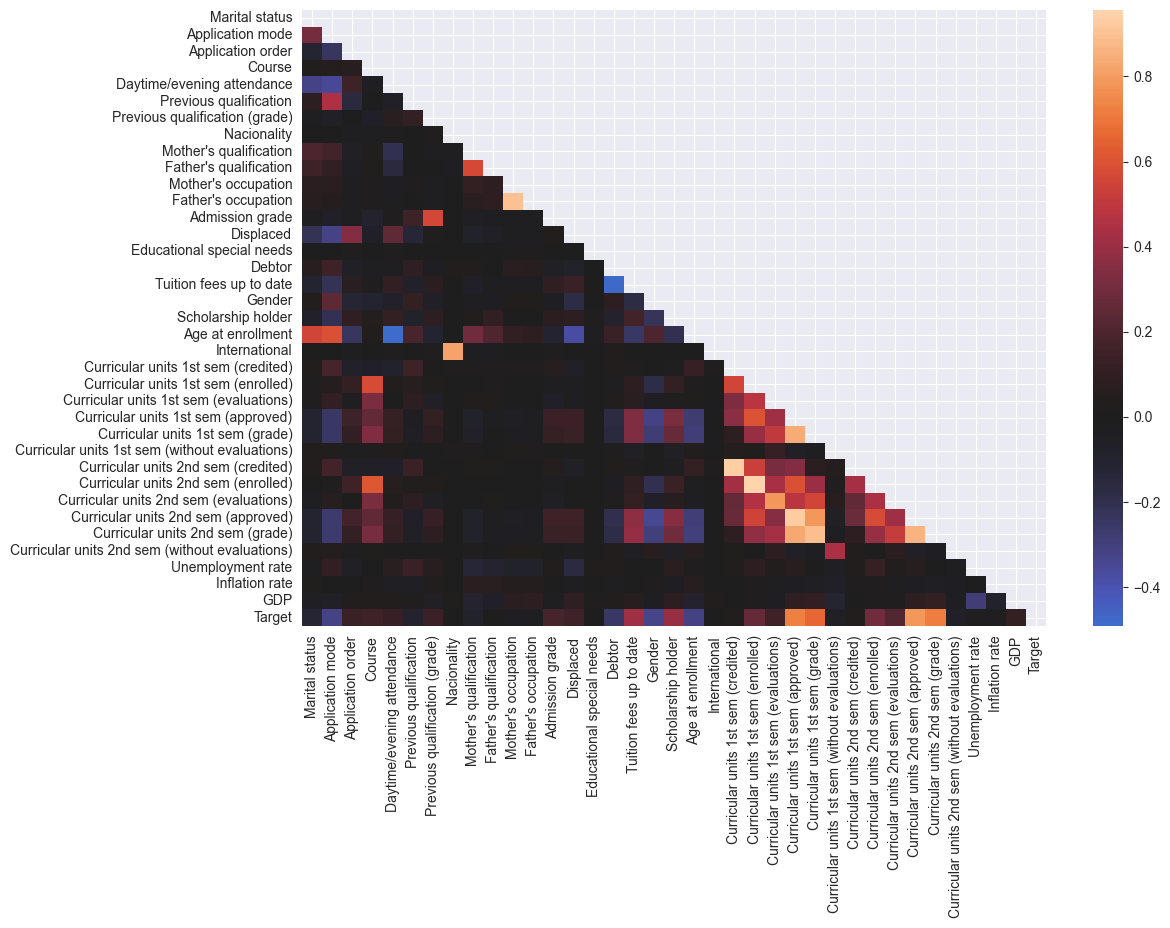

In [82]:
plot_correlation(train.corr())

## Mutual Information

In [90]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=42, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=True)
    return mi_scores

mi_scores = make_mi_scores(train.drop(columns="Target"), train["Target"])

<Axes: >

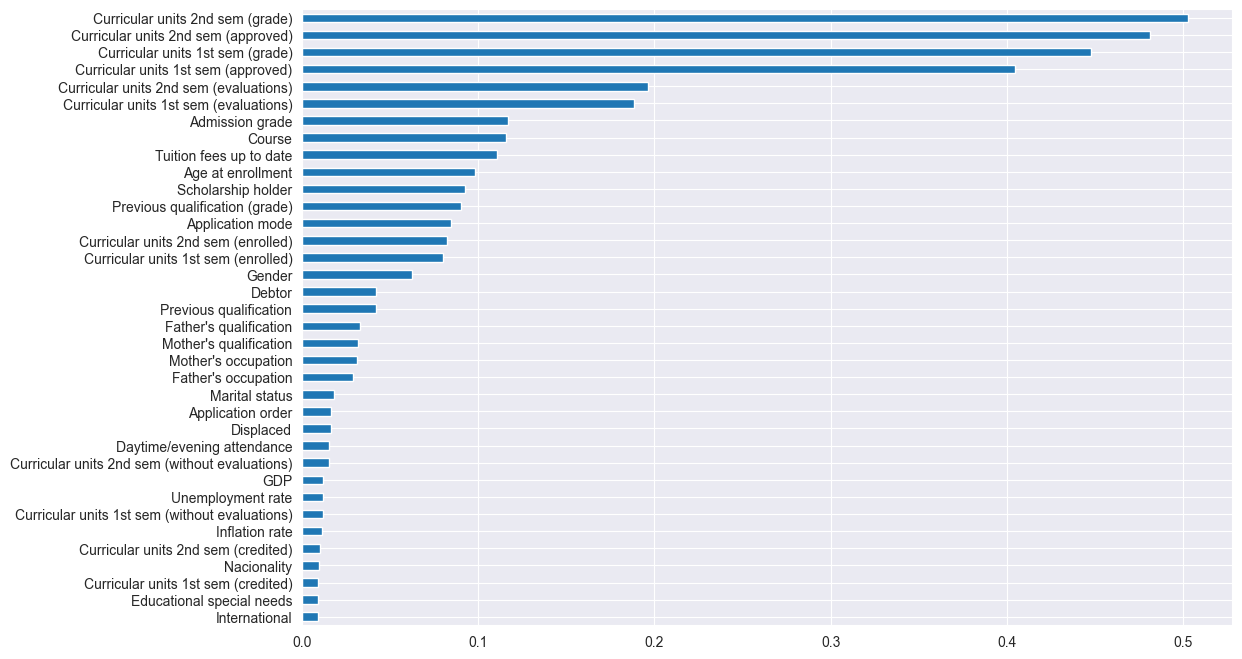

In [91]:
mi_scores.plot.barh(figsize=(12,8))

## Feature Distribution

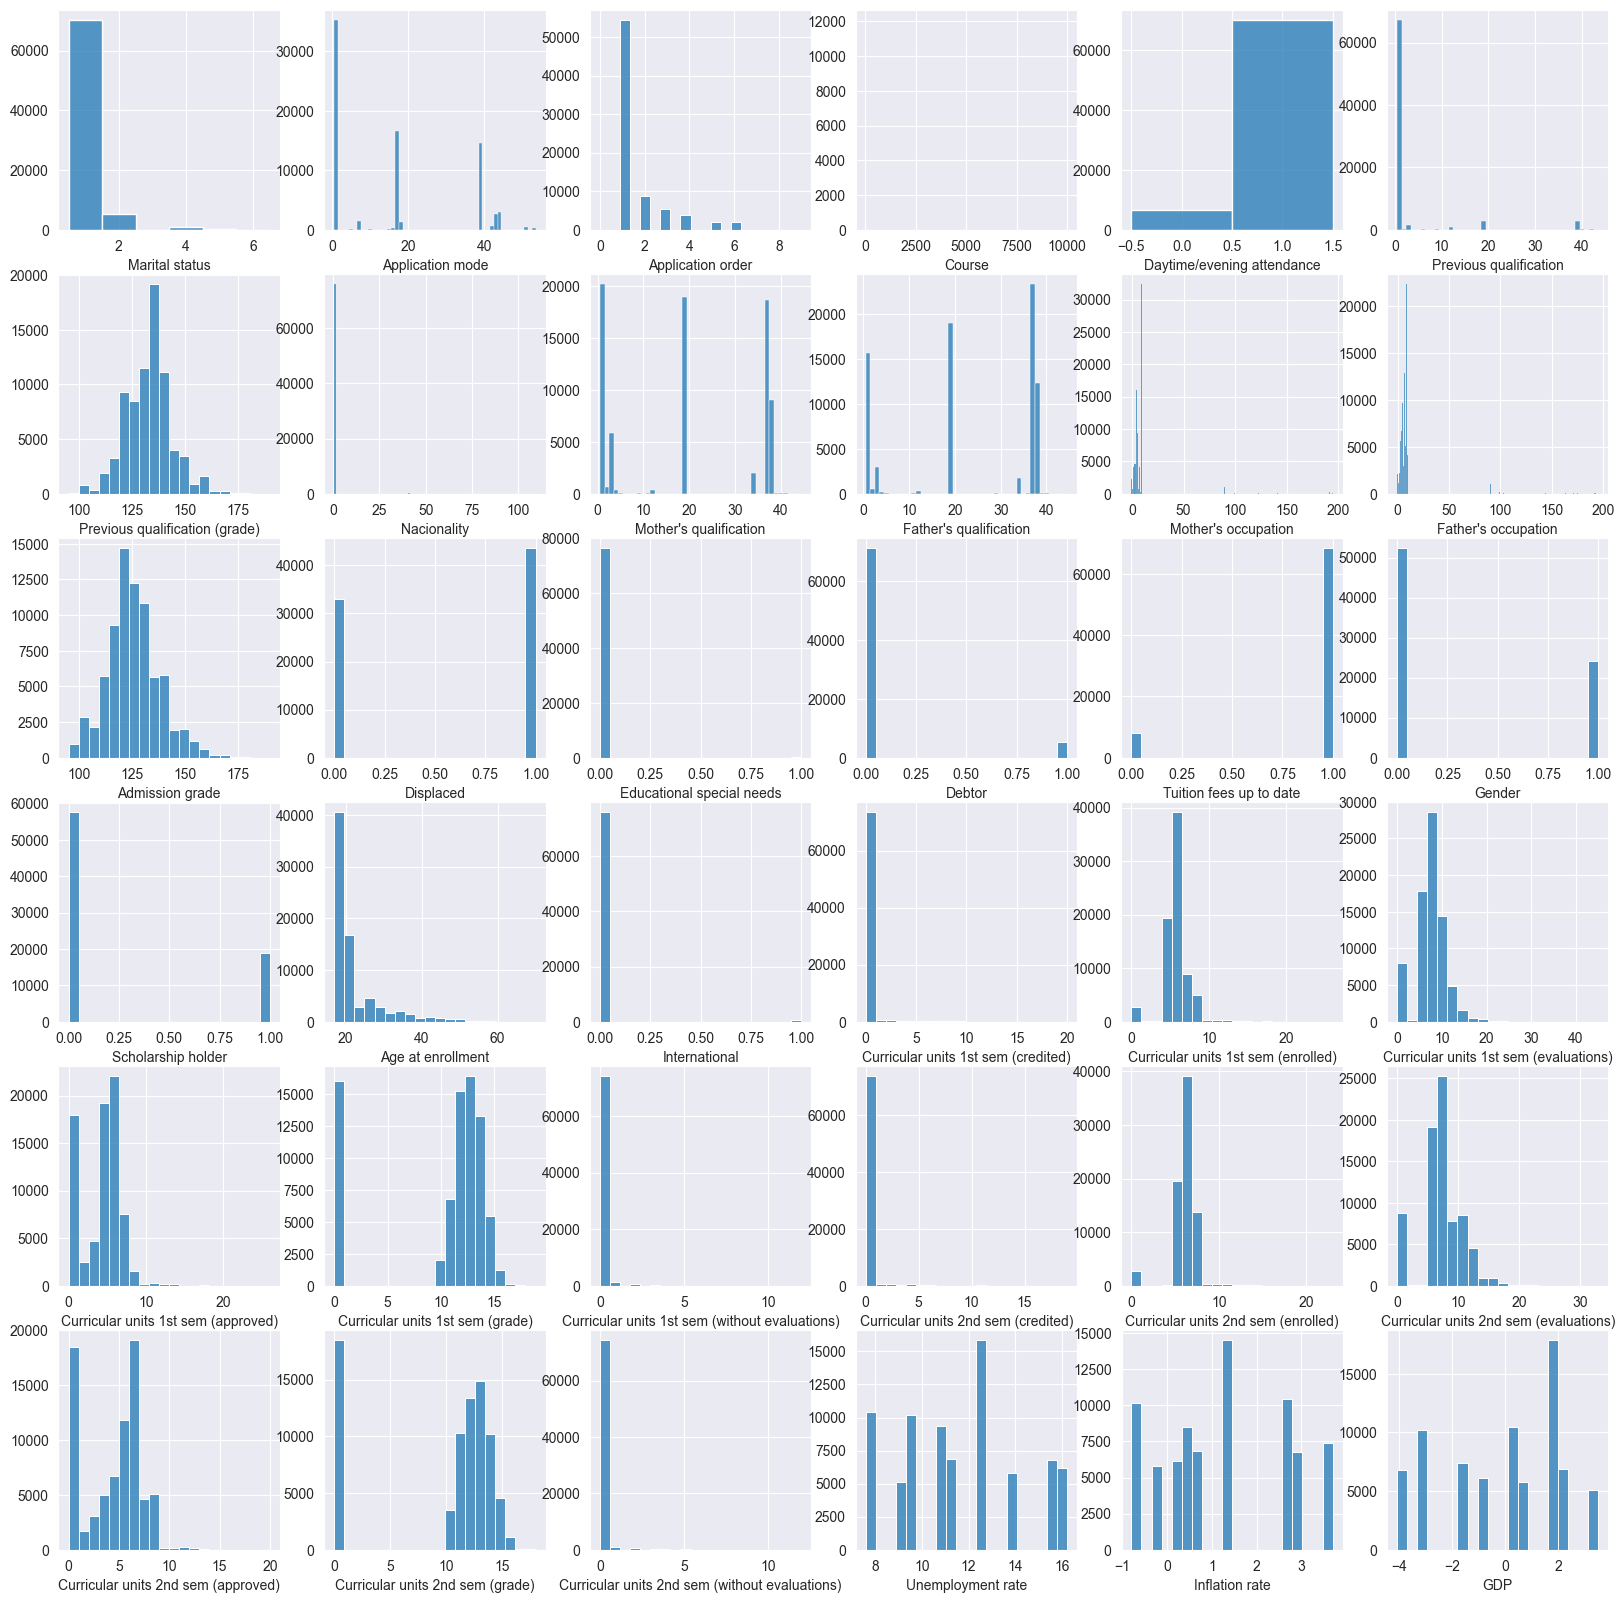

In [106]:
features = np.reshape(train.drop(columns="Target").columns, (6,6))

fig, axs = plt.subplots(6, 6, figsize=(20, 20))

for i in range(6):
    for j in range(6):
        ax = sns.histplot(x=train[features[i][j]], ax=axs[i][j], bins=20)
        ax.set_ylabel(None)

### Closer Look at boolean data

Text(0, 0.5, '')

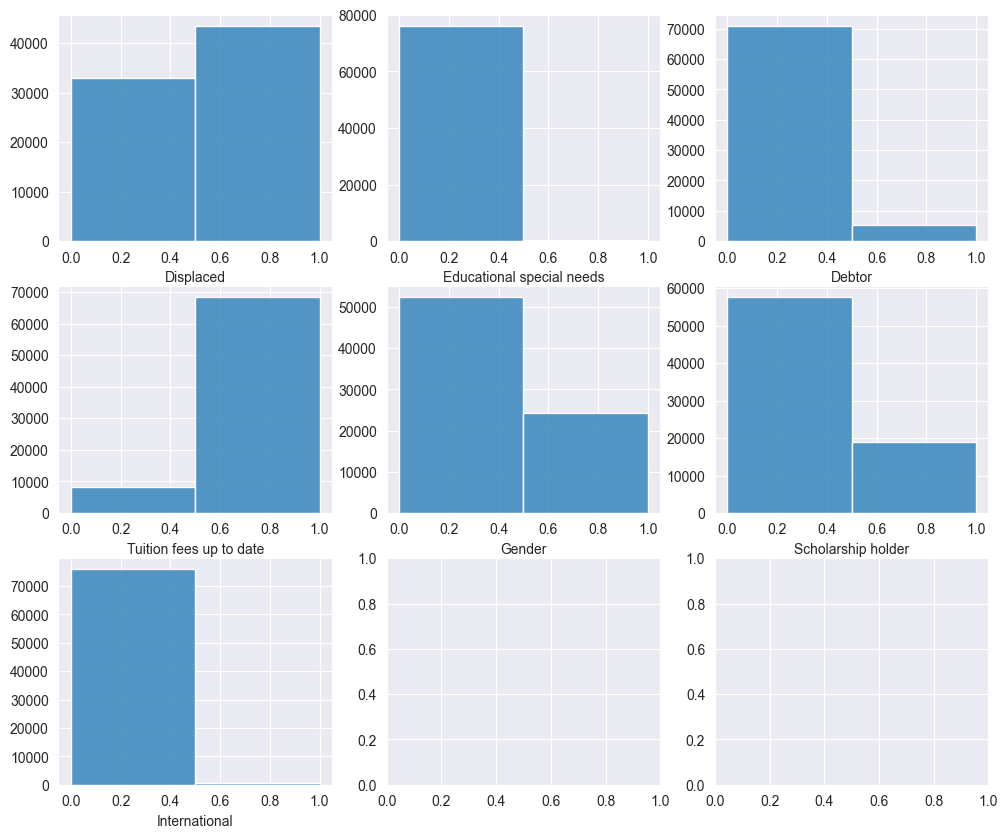

In [125]:
bools = train.select_dtypes("bool").columns
features = np.reshape(bools[:-1], (2,3))

fig, axs = plt.subplots(3, 3, figsize=(12, 10))

for i in range(2):
    for j in range(3):
        ax = sns.histplot(x=train[features[i][j]], ax=axs[i][j], bins=2)
        ax.set_ylabel(None)
        
ax = sns.histplot(x=train[bools[-1]], ax=axs[2][0], bins=2)
ax.set_ylabel(None)

## Target Distribution

<Axes: xlabel='Target', ylabel='Count'>

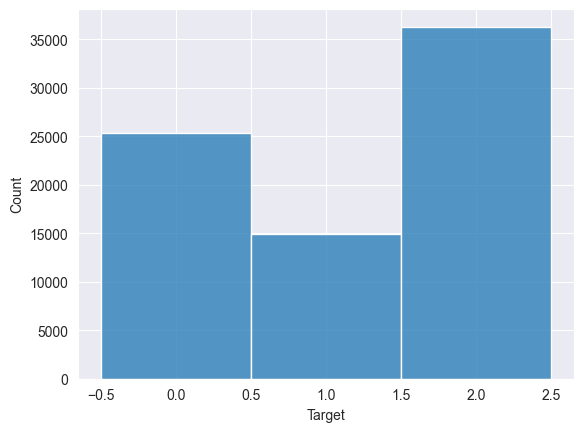

In [127]:
sns.histplot(x=train.Target)